# Decision Point Analysis

In [1]:
import pandas as pd
import numpy as np
from datetime import date
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#!pip install pm4py --user
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery


# viz
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.footprints import visualizer as fp_visualizer
from pm4py.visualization.transition_system import visualizer as ts_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# conformance
from pm4py.algo.conformance.footprints import algorithm as fp_conformance
from pm4py import conformance_diagnostics_token_based_replay
from pm4py.algo.conformance.alignments.edit_distance import algorithm as logs_alignments

# misc 
from pm4py.objects.petri_net.utils import reachability_graph
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.objects.petri_net.obj import PetriNet, Marking

import pm4py

### Read event log

In [3]:
fn = 'request_data_extended.csv'
events = pd.read_csv(fn,sep=';')
events['Timestamp'] = pd.to_datetime(events['Timestamp'],format='%d-%m-%Y:%H.%M')

In [4]:
activitynames = {'register_request': 'a_register_request',
                 'examine_thoroughly': 'b_examine_thoroughly',
                    'examine_casually': 'c_examine_casually',
                    'check_ticket': 'd_check_ticket',
                    'decide': 'e_decide',
                    'reinitiate_request': 'f_reinitiate_request',
                    'pay_compensation': 'g_pay_compensation',
                    'reject_request': 'h_reject_request'
                 }

In [5]:
# rename values in row 'Activity' to the values in activitynames
events['Activity'] = events['Activity'].map(activitynames)

In [6]:
events

,Case_ID,Event_ID,Timestamp,Activity,Resource,Amount,Year
0,1,35654423,2010-12-30 11:02:00,a_register_request,Pete,high,2022
1,1,35654424,2010-12-31 10:06:00,b_examine_thoroughly,Sue,high,2022
2,1,35654425,2011-01-05 15:12:00,d_check_ticket,Mike,high,2022
3,1,35654426,2011-01-06 11:18:00,e_decide,Sara,high,2022
4,1,35654427,2011-01-07 14:24:00,h_reject_request,Pete,high,2022
5,2,35654483,2010-12-30 11:32:00,a_register_request,Mike,low,2023
6,2,35654485,2010-12-30 12:12:00,d_check_ticket,Mike,low,2023
7,2,35654487,2010-12-30 14:16:00,c_examine_casually,Pete,low,2023
8,2,35654488,2011-01-05 11:22:00,e_decide,Sara,low,2023
9,2,35654489,2011-01-08 12:05:00,g_pay_compensation,Ellen,low,2023


In [7]:
events.shape

(42, 7)

In [8]:
# new column with all prior activities
events['Previous_Activities'] = events.groupby('Case_ID')['Activity'].transform(lambda x: [list(x)[:i] for i, y in enumerate(x)])
events['Throroughly_Examined'] = events['Previous_Activities'].apply(lambda x: 1 if ('b_examine_thoroughly' in x) else 0)
events['Casually_Examined'] = events['Previous_Activities'].apply(lambda x: 1 if ('c_examine_casually' in x) else 0)
events.head()

,Case_ID,Event_ID,Timestamp,Activity,Resource,Amount,Year,Previous_Activities,Throroughly_Examined,Casually_Examined
0,1,35654423,2010-12-30 11:02:00,a_register_request,Pete,high,2022,[],0,0
1,1,35654424,2010-12-31 10:06:00,b_examine_thoroughly,Sue,high,2022,[a_register_request],0,0
2,1,35654425,2011-01-05 15:12:00,d_check_ticket,Mike,high,2022,"[a_register_request, b_examine_thoroughly]",1,0
3,1,35654426,2011-01-06 11:18:00,e_decide,Sara,high,2022,"[a_register_request, b_examine_thoroughly, d_c...",1,0
4,1,35654427,2011-01-07 14:24:00,h_reject_request,Pete,high,2022,"[a_register_request, b_examine_thoroughly, d_c...",1,0


In [12]:
# new columne in events shifting the activity one row down
events['Next_Activity'] = events.groupby('Case_ID')['Activity'].shift(-1)
events['Next_Next_Activity'] = events.groupby('Case_ID')['Activity'].shift(-2)

# add new column with the examination type
check_thorough = lambda x: "Thorough" if ((x['Next_Activity'] == 'b_examine_thoroughly') or (x['Next_Next_Activity'] == 'b_examine_thoroughly')) else ("Casual" if ((x['Next_Activity'] == 'c_examine_casually') or (x['Next_Next_Activity'] == 'c_examine_casually')) else "Other")
events['Examination'] = events.apply(check_thorough,axis=1)

events.head()

,Case_ID,Event_ID,Timestamp,Activity,Resource,Amount,Year,Previous_Activities,Throroughly_Examined,Casually_Examined,Next_Activity,Next_Next_Activity,Examination
0,1,35654423,2010-12-30 11:02:00,a_register_request,Pete,high,2022,[],0,0,b_examine_thoroughly,d_check_ticket,Thorough
1,1,35654424,2010-12-31 10:06:00,b_examine_thoroughly,Sue,high,2022,[a_register_request],0,0,d_check_ticket,e_decide,Other
2,1,35654425,2011-01-05 15:12:00,d_check_ticket,Mike,high,2022,"[a_register_request, b_examine_thoroughly]",1,0,e_decide,h_reject_request,Other
3,1,35654426,2011-01-06 11:18:00,e_decide,Sara,high,2022,"[a_register_request, b_examine_thoroughly, d_c...",1,0,h_reject_request,NaN,Other
4,1,35654427,2011-01-07 14:24:00,h_reject_request,Pete,high,2022,"[a_register_request, b_examine_thoroughly, d_c...",1,0,NaN,NaN,Other


In [52]:
# select only decision rows and columns Amount, Year, Throughly_Examined, Rejected
decision_df = events[(events['Activity'] == 'a_register_request') | (events['Activity'] == 'f_reinitiate_request')][['Amount','Year','Casually_Examined','Throroughly_Examined','Examination']].copy().reset_index(drop=True)
decision_df

,Amount,Year,Casually_Examined,Throroughly_Examined,Examination
0,high,2022,0,0,Thorough
1,low,2023,0,0,Casual
2,high,2023,0,0,Casual
3,high,2023,1,0,Thorough
4,high,2022,0,0,Thorough
5,high,2022,0,0,Casual
6,high,2022,1,0,Casual
7,high,2022,1,0,Thorough
8,low,2023,0,0,Casual


In [53]:
# use sklearn onehotencoder to create dummy variables for the Amount and Year columns
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(decision_df[['Amount','Year']])
enc.categories_


[array(['high', 'low'], dtype=object), array([2022, 2023], dtype=int64)]

In [54]:
# add the dummy variables to the dataframe
decision_df = pd.concat([decision_df,pd.DataFrame(enc.transform(decision_df[['Amount','Year']]).toarray(),columns=['Amount_High','Amount_Low','Year_2022','Year_2023'])],axis=1)  



In [55]:
# drop columns Amount, Year, Amount_Low and Year_2022
decision_df.drop(['Amount','Year','Amount_Low','Year_2022'],axis=1,inplace=True)
decision_df

,Casually_Examined,Throroughly_Examined,Examination,Amount_High,Year_2023
0,0,0,Thorough,1.0,0.0
1,0,0,Casual,0.0,1.0
2,0,0,Casual,1.0,1.0
3,1,0,Thorough,1.0,1.0
4,0,0,Thorough,1.0,0.0
5,0,0,Casual,1.0,0.0
6,1,0,Casual,1.0,0.0
7,1,0,Thorough,1.0,0.0
8,0,0,Casual,0.0,1.0


In [56]:
# create decision tree for Rejected with sklearn tree
from sklearn.tree import DecisionTreeClassifier
#clf = DecisionTreeClassifier(random_state=0, criterion="gini",min_samples_leaf=2)
clf = DecisionTreeClassifier(random_state=0, criterion="gini")
#clf.fit(decision_df[['Amount_High','Year_2023','Throroughly_Examined']], decision_df['Rejected'])
clf.fit(decision_df[['Amount_High','Casually_Examined','Throroughly_Examined']], decision_df['Examination'])





DecisionTreeClassifier(random_state=0)

In [57]:
y_predict = clf.predict(decision_df[['Amount_High','Casually_Examined','Throroughly_Examined']])
y_predict

array(['Casual', 'Casual', 'Casual', 'Thorough', 'Casual', 'Casual',
       'Thorough', 'Thorough', 'Casual'], dtype=object)

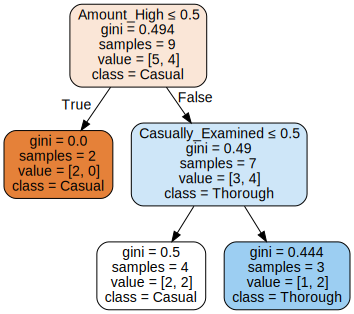

In [58]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(clf,
                                out_file=None, 
                      feature_names=list(clf.feature_names_in_),  
                      class_names=list(clf.classes_),  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  

graph